# Introduction 

In this section of the IBM Data Science capstone, I'll be using the Space X API data to generate a predictive model which will allow us to determine if a Falcon 9 launch will successfully land.

I'll be using some data that has already been prepared by the IBM course designers. The data is split into two files. They are based on the same data, but one has been one-hot encoded and the other isn't. 

I have a gripe with this data, and I suppose with the capstone in its entirety I guess: we've been switching between the data from the API and the data scraped from Wikipedia and to me it would make more sense to only be using one. Granted, many of the instances in the datasets refer to the same launch, there are more launches in the Wikipedia set than the API set. It would make more sense to just use one for the whole project, or join the two datasets so we have more features for each launch instance. Doing that would inevitably result in more work from a data cleaning perspective, because we'd probably have around 40+ data instances with incomplete data.

In a future project I won't necessarily have this problem, but I wanted to make note of this experience for anyone reading through my project.

Regardless of my opinions, let's continue by importing the two datasets:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('datasets/for_ML/dataset_part_2.csv')
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [3]:
X = pd.read_csv('datasets/for_ML/dataset_part_3.csv')
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


### Task 1

Create the target array:

In [4]:
Y = data['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

### Task 2

Standardize the data in `X`:

In [5]:
std_scaler = preprocessing.StandardScaler()
X = std_scaler.fit_transform(X)  # output is a numpy array
X

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -8.35531692e-01, -5.17306132e-01,  5.17306132e-01]])

### Task 3

Split the data into training and testing sets:

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(72, 83) (18, 83) (72,) (18,)


We can see that we have 72 training samples and 18 test samples. However, notice that the class distribution is unbalanced:

In [7]:
unique, counts = np.unique(Y_train, return_counts=True)
print('Y_train class balance:\n', np.asarray((unique, counts)).T)
unique, counts = np.unique(Y_test, return_counts=True)
print('Y_test class balance:\n', np.asarray((unique, counts)).T)

Y_train class balance:
 [[ 0 24]
 [ 1 48]]
Y_test class balance:
 [[ 0  6]
 [ 1 12]]


In the original `Y` dataframe, we have the following balance:

In [8]:
data['Class'].value_counts()

1    60
0    30
Name: Class, dtype: int64

So we have the same distribution between successful and unsuccessful launches in both `Y_train` and `Y_test` as we do in the original dataset. This is an optimal situation. To increase model performance, we may also undersample the positive class or oversample the negative class to bring the classes into a 50/50 balance.

### Task 4

Training a logistic regression model.

In [9]:
params = {'C': [0.01, 0.1, 1], 'penalty': ['l2'], 'solver': ['lbfgs']}
l_reg = LogisticRegression()

logreg_cv = GridSearchCV(l_reg, params, n_jobs=-1, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [10]:
print("tuned hyperparameters: ", logreg_cv.best_params_)
print("accuracy: ", logreg_cv.best_score_)

tuned hpyerparameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy:  0.8464285714285713


### Task 5

Evaluate the model with `score()`.

In [11]:
best_model_logreg = logreg_cv.best_estimator_

best_model_logreg.score(X_test, Y_test)

0.8333333333333334

In [12]:
yhat = best_model_logreg.predict(X_test)

confusion_matrix(Y_test, yhat)

array([[ 3,  3],
       [ 0, 12]])

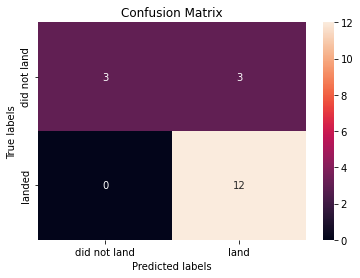

In [13]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    
plot_confusion_matrix(Y_test, yhat)

### Task 6

Train the SVM model:

In [14]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm_clf = SVC()

svm_clf_cv = GridSearchCV(svm_clf, parameters, n_jobs=-1, cv=10)
svm_clf_cv.fit(X_train, Y_train)

print("tuned hyperparameters: ", svm_clf_cv.best_params_)
print("accuracy: ", svm_clf_cv.best_score_)

svm_clf_best = svm_clf_cv.best_estimator_

tuned hpyerparameters:  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy:  0.8482142857142856


### Task 7

Use `score()` to evaluate the SVM classifier:

In [15]:
svm_clf_best.score(X_test, Y_test)

0.8333333333333334

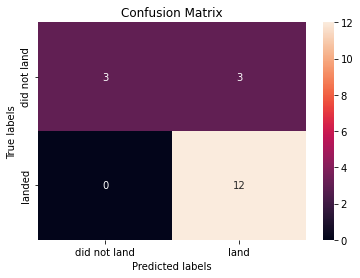

In [17]:
yhat = svm_clf_best.predict(X_test)

plot_confusion_matrix(Y_test, yhat)

### Task 8

Train the decision tree classifier:

In [20]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
#      'max_features': ['auto', 'sqrt'],  # feature is deprecated
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_grid_cv = GridSearchCV(tree, parameters, n_jobs=-1, cv=10)
tree_grid_cv.fit(X_train, Y_train)

print("tuned hyperparameters: ", tree_grid_cv.best_params_)
print("accuracy: ", tree_grid_cv.best_score_)

best_tree_cv = tree_grid_cv.best_estimator_

tuned hpyerparameters:  {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
accuracy:  0.8714285714285713


### Task 9

Use `score()` on the decision tree:

In [21]:
best_tree_cv.score(X_test, Y_test)

0.7777777777777778

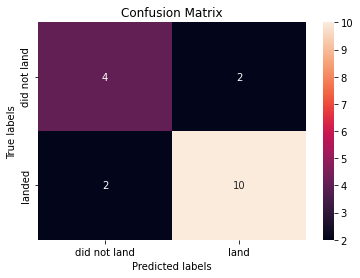

In [22]:
yhat = best_tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

### Task 10

Train the KNN model:

In [23]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
KNN_grid_cv = GridSearchCV(KNN, parameters, cv=10, n_jobs=-1)
KNN_grid_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [24]:
print("tuned hyperparameters: ", KNN_grid_cv.best_params_)
print("accuracy: ", KNN_grid_cv.best_score_)

best_knn_cv = KNN_grid_cv.best_estimator_

tuned hpyerparameters:  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy:  0.8482142857142858


### Task 11

Use `score()` on the KNN model:

In [25]:
best_knn_cv.score(X_test, Y_test)

0.8333333333333334

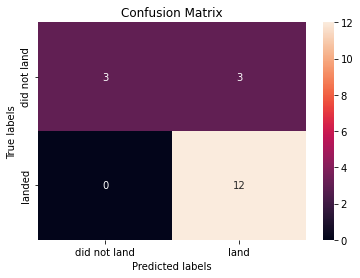

In [26]:
yhat = best_knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

### Task 12 

The decision tree classifier performs the worst out of the bunch, with an R^2 score of 0.77. However, it performs the best of all the models (0.87) during cross validation on the training set. This is indicative of an overfit model. Therefore we should look at the other models to decide which one to use.

All of the other models perform the same on the test set. The KNN and SVM models perform slightly better on the best round of cross validation than the logistic regression model. We can try the models on the full datasets:

In [28]:
print('KNN classifier score on full dataset: ', best_knn_cv.score(X, Y))
print('SVM classifier score on full dataset: ', svm_clf_best.score(X, Y))

KNN classifier score on full dataset:  0.8555555555555555
SVM classifier score on full dataset:  0.8777777777777778


Therefore the SVM classifier performs the best on our data.